In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
import ipywidgets as widgets
from IPython.display import display
from sklearn.metrics import precision_recall_fscore_support

ModuleNotFoundError: No module named 'torch'

In [ ]:
data = pd.read_csv('cancer.csv', index_col='Id')
X = data.drop(columns=['Diagnosis'])
y = data['Diagnosis']

data['Diagnosis'] = data['Diagnosis'].map({'B': 0, 'M': 1})


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  
)
y_train = y_train.map({'B': 0, 'M': 1})
y_test = y_test.map({'B': 0, 'M': 1})


# دیکشنری وزن‌ها (17 ویژگی اصلی با وزن‌های نرمال‌شده)
feature_weights = {
    'Perimeter (worst)': 0.0859,
    'Area (worst)': 0.0833,
    'Radius (worst)': 0.0809,
    'Concave points (mean)': 0.0798,
    'Concave points (worst)': 0.0791,
    'Perimeter (mean)': 0.0725,
    'Concavity (mean)': 0.0673,
    'Area (mean)': 0.0647,
    'Area (se)': 0.0607,
    'Concavity (worst)': 0.0575,
    'Perimeter (se)': 0.0491,
    'Radius (se)': 0.0440,
    'Compactness (worst)': 0.0408,
    'Compactness (mean)': 0.0381,
    'Concave points (se)': 0.0226,
    'Texture (worst)': 0.0216,
    'Texture (mean)': 0.0182,
    
}

# محاسبه وزن پیش‌فرض (میانگین وزن‌های موجود)
default_weight = np.mean(list(feature_weights.values()))

selected_features = list(feature_weights.keys())  
print(f"Selected features: {selected_features}")

X_train_filtered = X_train[selected_features]
X_test_filtered = X_test[selected_features]

weights_filtered = np.array([feature_weights[col] for col in selected_features])

X_train_weighted = X_train_filtered * weights_filtered
X_test_weighted = X_test_filtered * weights_filtered

X_train_tensor = torch.tensor(X_train_weighted.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_weighted.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)


Selected features: ['Perimeter (worst)', 'Area (worst)', 'Radius (worst)', 'Concave points (mean)', 'Concave points (worst)', 'Perimeter (mean)', 'Concavity (mean)', 'Area (mean)', 'Area (se)', 'Concavity (worst)', 'Perimeter (se)', 'Radius (se)', 'Compactness (worst)', 'Compactness (mean)', 'Concave points (se)', 'Texture (worst)', 'Texture (mean)']


In [155]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Training data: {len(train_loader.dataset)} samples")
print(f"Test data: {len(test_loader.dataset)} samples")
for x, y in test_loader:
    print(f"Shape of X [N, C]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Training data: 455 samples
Test data: 114 samples
Shape of X [N, C]: torch.Size([64, 17])
Shape of y: torch.Size([64]) torch.int64


Text(0.5, 1.0, 'Correlation Heatmap')

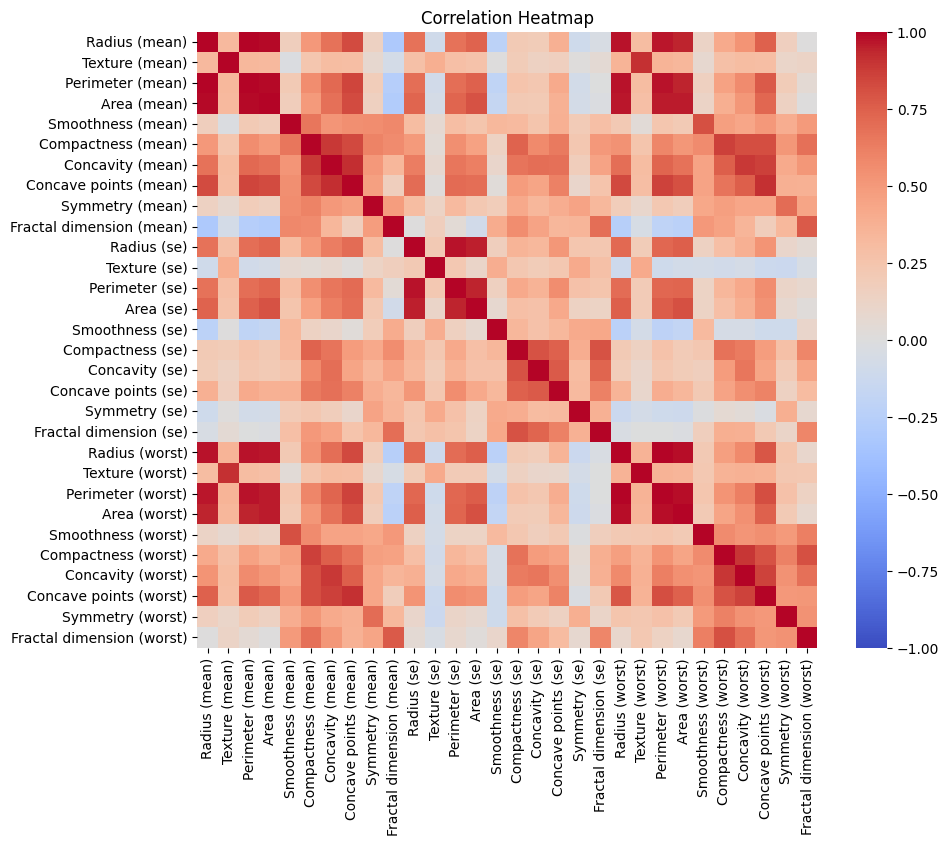

In [ ]:
correlation_matrix = X.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap')


In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# model

In [137]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(17, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 512),
            nn.LeakyReLU(),
            nn.Linear(512,2)
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=17, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
)


# train

In [ ]:

# from tqdm import tqdm
# n_epochs = 40
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # کاهش نرخ یادگیری
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# for _ in (pbar := tqdm(range(n_epochs))):
#     for x, y in train_loader:
#         x, y = x.to(device), y.to(device)
#         optimizer.zero_grad()
        
#         pred = model(x)
#         loss = loss_fn(pred, y)
#         loss.backward()
        
#         optimizer.step()
#         pbar.set_description(f'Loss = {loss.item():.3f}')
#     scheduler.step()  # کاهش نرخ یادگیری هر 10 دوره


Loss = 0.173: 100%|██████████| 40/40 [00:04<00:00,  9.52it/s]


Avg Loss = 0.047: 100%|██████████| 100/100 [00:08<00:00, 11.41it/s]


Chart saved as 'training_loss.png'


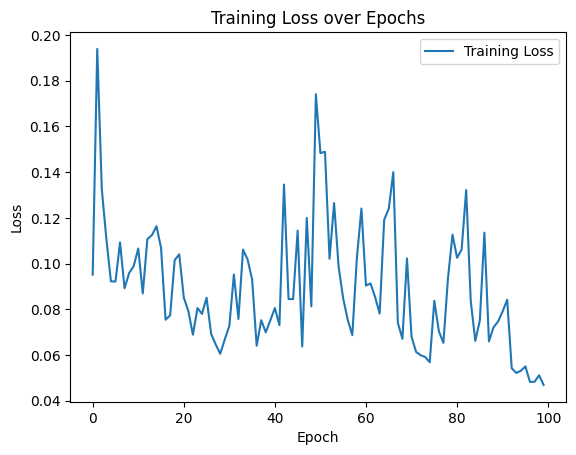

In [ ]:
n_epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []

for _ in (pbar := tqdm(range(n_epochs))):
    model.train()
    epoch_loss = 0
    num_batches = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        num_batches += 1

    avg_epoch_loss = epoch_loss / num_batches
    train_losses.append(avg_epoch_loss)
    pbar.set_description(f'Avg Loss = {avg_epoch_loss:.3f}')

plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.savefig('training_loss.png')
print("Chart saved as 'training_loss.png'")

In [ ]:
model.eval()
correct, total = 0, 0

# Disable gradient calculation
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        pred = torch.argmax(logits, axis=1)
        correct += sum(pred == y).item()
        total += pred.shape[0]

print(f'Accuracy: {100 * correct / total:.2f}%')

Accuracy: 92.98%


In [ ]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        pred = torch.argmax(logits, dim=1)
        all_preds.extend(pred.cpu().numpy())  
        all_labels.extend(y.cpu().numpy())

accuracy = 100 * sum([p == l for p, l in zip(all_preds, all_labels)]) / len(all_labels)
print(f'Test Accuracy: {accuracy:.2f}%')

precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

Test Accuracy: 92.98%
Precision: 1.00
Recall: 0.81
F1-Score: 0.89


Dropdown(description='Optimizer:', layout=Layout(width='200px'), options=('SGD', 'AdaGrad', 'RMSProp', 'Adam')…

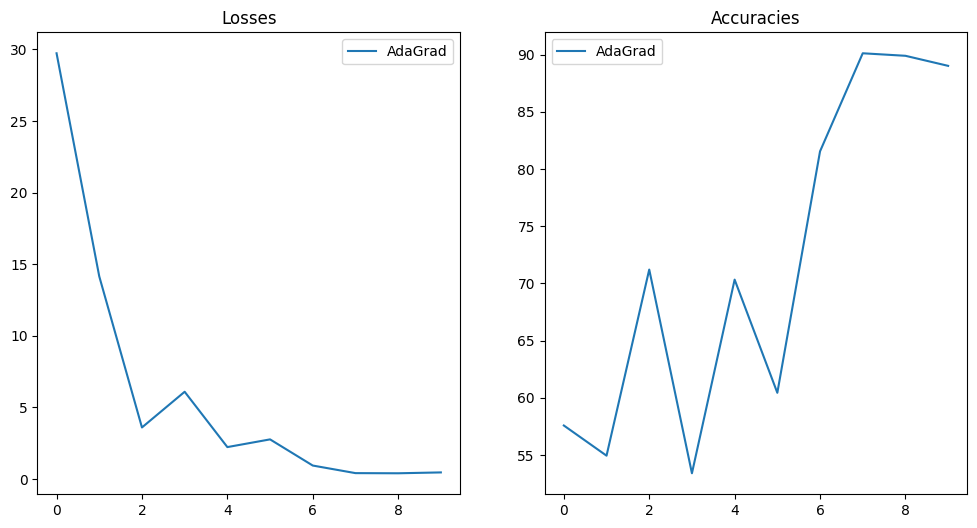

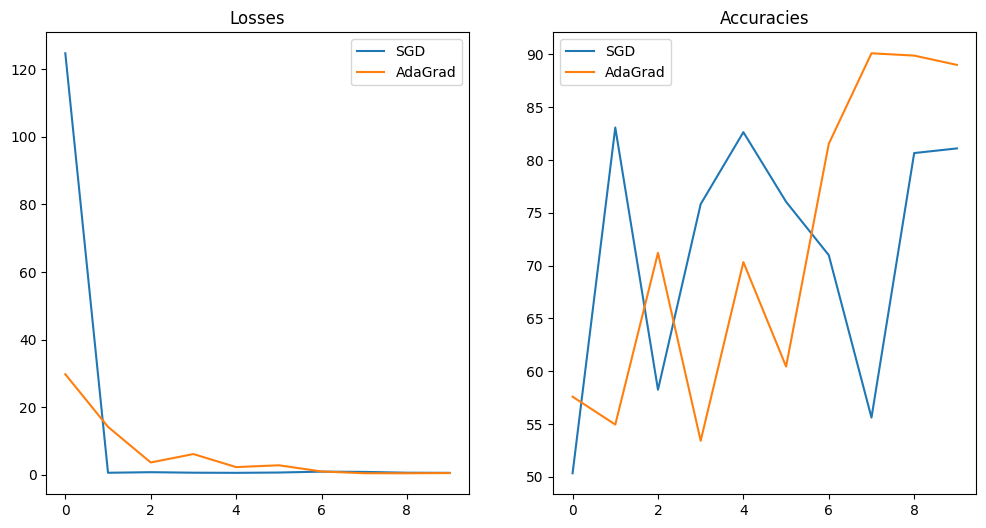

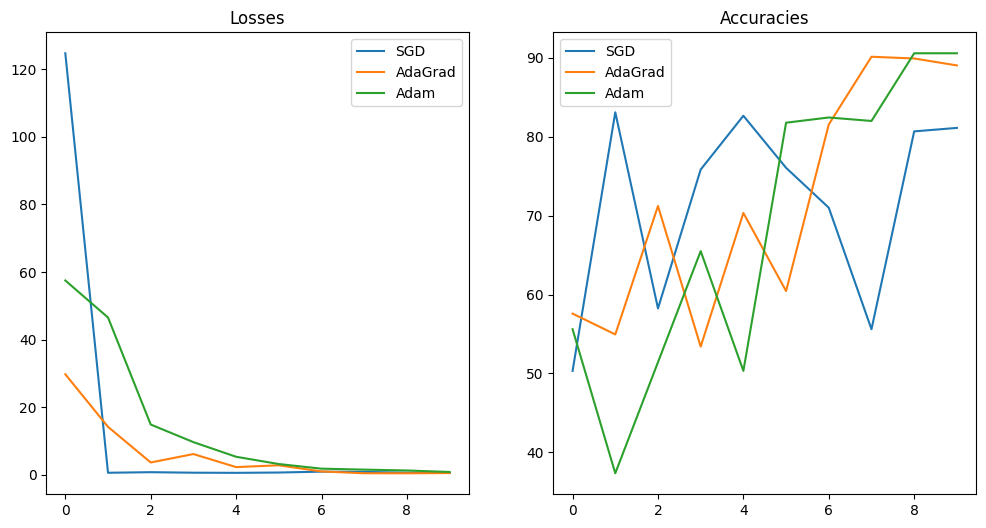

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=128)

def train_model(model, optimizer, n_epochs=10):
    losses, accuracies = [], []
    for _ in (pbar := tqdm(range(n_epochs))):
        running_loss, acc = 0, 0
        for x, y in train_dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.item()
            pred = torch.argmax(pred, axis=1)
            acc += sum(pred == y).item()
        acc /= len(train_dataloader.dataset)
        acc *= 100
        running_loss /= len(train_dataloader)
        losses.append(running_loss)
        accuracies.append(acc)
        pbar.set_description(f'Loss = {running_loss:.3f} | Accuracy = {acc:.2f}% ')
    return losses, accuracies


def plot_losses_accuracies(results):
    fig, axes = plt.subplots(1, 2)
    for optimizer, res in results.items():
        if 'losses' not in res or 'accuracies' not in res:
            continue
        losses = res['losses']
        accuracies = res['accuracies']
        axes[0].plot(losses, label=optimizer)
        axes[1].plot(accuracies, label=optimizer)
    axes[0].set_title('Losses')
    axes[1].set_title('Accuracies')
    axes[0].legend()
    axes[1].legend()
    fig.set_size_inches(12, 6)
    plt.show()

options = ['SGD', 'AdaGrad', 'RMSProp', 'Adam']

dropdown = widgets.Dropdown(
    options=options,
    description='Optimizer:',
    layout={'width': '200px'},
    style={'description_width': 'initial'}

)

def on_value_change(change):
    optimizer = change['new']
    global first_run, resuts
    model = NeuralNetwork().to(device)
    if results[optimizer] != {}:
        losses = results[optimizer]['losses']
        accuracies = results[optimizer]['accuracies']
        plot_losses_accuracies(results)
        return
    if optimizer == 'SGD':
        opt = torch.optim.SGD(model.parameters(), lr=1e-3)
    elif optimizer == 'AdaGrad':
        opt = torch.optim.Adagrad(model.parameters(), lr=1e-3)
    elif optimizer == 'RMSProp':
        opt = torch.optim.RMSprop(model.parameters(), lr=1e-3)
    elif optimizer == 'Adam':
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    print(f'\n{optimizer}')
    losses, accuracies = train_model(model, opt)
    results[optimizer]['losses'] = losses
    results[optimizer]['accuracies'] = accuracies
    plot_losses_accuracies(results)


dropdown.observe(on_value_change, names='value')

results = {optimizer: dict() for optimizer in options}

display(dropdown)